### Objectifs 
* rasterize labels
* stack different data sources :
    * s1 and s2
    * band selection | polarization
    * labels
* save dataset and labels as np.array (.npy)

In [1]:
import geopandas as gpd 
import numpy as np 
import os
import matplotlib.pyplot as plt 
import rasterio as rio 
import rioxarray as rioxr
import pandas as pd
import xarray as xr

In [2]:
project_dir = "/home/rustt/Documents/Projects/S1_S2_classification"
data_dir = os.path.join(project_dir, "sentinel_classification/data/processed")
out_dir = os.path.join(project_dir, "sentinel_classification/data/final")
out_rs_labels = os.path.join(data_dir, "labels_rasterized.tif")

s2_stack_path = os.path.join(data_dir, "s2", "clip_s2_pan_sharp.tif")
s1_stack_path =  os.path.join(data_dir, "s1", "clip_S1B_20180114_VV_Sig0_Ortho_TempFilt_W11_dB.tif")

In [3]:
s2_stack = rioxr.open_rasterio(s2_stack_path)
s1_stack = rioxr.open_rasterio(s1_stack_path)

In [4]:
labels = gpd.read_file(os.path.join(data_dir, "ROI_Classif_corrected.shp"))

### Extract label class for each pixel 
* Rasterize labels and concat as variable

In [5]:
ds_s2_stack = s2_stack.to_dataset(dim="band")

In [6]:
with rio.open(os.path.join(data_dir, "s2", "clip_s2_pan_sharp.tif")) as rs_src:
    meta = rs_src.meta.copy()
    meta.update(compress='lzw')
    
    with rio.open(out_rs_labels, 'w+', **meta) as out:
        out_arr = out.read(1)
    
        shapes = ((geom,value) for geom, value in zip(labels.geometry, labels.classid))
    
        burned = rio.features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform)
        out.write_band(1, burned)

In [7]:
labels_rs = rioxr.open_rasterio(out_rs_labels)

In [8]:
classid_da = xr.DataArray(
    labels_rs.sel(band=1).values, 
    dims=['y', 'x'], 
    coords={'y': ds_s2_stack['y'], 'x': ds_s2_stack['x']}
)
# change classid type to int8/int16

In [9]:
ds_s2_stack["classid"] = classid_da

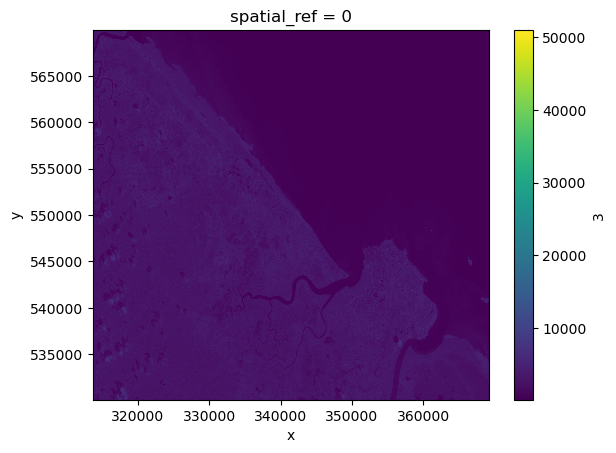

In [15]:
ds_s2_stack[3].plot()

## Make dataset

### Stack different data sources

* input : data source names + channel | polarization wanted
* output : xarray dataset 

In [91]:
s2_stack.to_dataset

<xarray.DataArray (band: 10, y: 4011, x: 5592)>
[224295120 values with dtype=float32]
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 10
  * x            (x) float64 3.137e+05 3.137e+05 ... 3.692e+05 3.692e+05
  * y            (y) float64 5.699e+05 5.699e+05 ... 5.301e+05 5.301e+05
    spatial_ref  int64 0
Attributes: (12/16)
    AREA_OR_POINT:             Area
    DataType:                  3
    METADATATYPE:              OTB
    NoData:                    0
    OTB_VERSION:               8.1.0
    STATISTICS_APPROXIMATE:    YES
    ...                        ...
    STATISTICS_VALID_PERCENT:  100
    TileHintX:                 128
    TileHintY:                 128
    _FillValue:                0.0
    scale_factor:              1.0
    add_offset:                0.0

In [92]:
from enum import Enum 
from typing import Any, List, Dict

class Polarization(Enum):
    VV="VV"
    VH="VH"
    VH_VV="VH-VV"

data_sources_names = [
    {"name":"s2", "bands":[1, 2, 3], "path":s2_stack_path},
    {"name":"s1", "bands":[Polarization.VV]},
]


def load_rs_xarray(path):
    return rioxr.open_rasterio(path)

class DatasetBuilder: 
    lat = "y"
    lon = "x"
    """
    Stack data sources : 
        - data sources are processing in tif format
        - all the data sources have the same geo mapping
    """
    def __init__(self, data_sources: List):
        self.data_sources = data_sources
        
    def create_dataset(self) -> xr.Dataset: 
        stack = []
        for ds_dict in self.data_sources: 
            stack.append(self._stack_ds(**ds_dict))

        # TODO : check if datasources share same mapping and attrs; take the first for simplicity
        array_stack = {var_k:arr for d in stack for var_k, arr in d["array_stack"].items()}
        #print(array_stack)
        coords = stack[0]["coords"]
        
        ds = xr.Dataset(
            data_vars=array_stack,
            coords=coords,
            attrs={}
        )
        return ds
            
    def _stack_ds(self, name, **kwargs) -> Dict[str, Dict]: 
        array_stack = {}
        ds = load_rs_xarray(kwargs["path"])
        selected_bands = kwargs["bands"] if kwargs["bands"] else range(1, len(ds.band)+1)
        for band in selected_bands:
            var_name = f"{name}_{band}" if name !="classid" else "classid"
            array_stack[var_name] = ((self.lat, self.lon), ds.sel(band=band).values)
            
        attrs = ds.attrs 
        # TODO : modify to do once after check
        coords = dict(y=ds.coords["y"].values, x=ds.coords["x"].values)
        del ds
        return dict(array_stack=array_stack, coords=coords, attrs=attrs)

A finir : 
* convert DN to reflectance
* stack polarization into s1_stack

In [78]:
ds.coords["x"].values

array([313663.21806348, 313673.15710582, 313683.09614817, ...,
       369212.52573515, 369222.4647775 , 369232.40381984])

In [93]:
builder = DatasetBuilder(
                data_sources=[
                    {"name":"s2", "bands":[], "path":s2_stack_path}, 
                    {"name":"s1", "bands":[], "path":s1_stack_path}, 
                    {"name":"classid", "bands":[], "path":out_rs_labels}
                ])
ds = builder.create_dataset()

In [94]:
ds

<xarray.Dataset>
Dimensions:  (y: 4011, x: 5592)
Coordinates:
  * y        (y) float64 5.699e+05 5.699e+05 5.699e+05 ... 5.301e+05 5.301e+05
  * x        (x) float64 3.137e+05 3.137e+05 3.137e+05 ... 3.692e+05 3.692e+05
Data variables:
    s2_1     (y, x) float32 603.5 587.2 588.7 576.0 ... 465.0 478.8 492.1 492.2
    s2_2     (y, x) float32 1.668e+03 1.619e+03 ... 1.183e+03 1.178e+03
    s2_3     (y, x) float32 4.033e+03 3.933e+03 ... 2.239e+03 2.213e+03
    s2_4     (y, x) float32 3.559e+03 3.432e+03 3.58e+03 ... 1.879e+03 1.853e+03
    s2_5     (y, x) float32 3.614e+03 3.517e+03 3.512e+03 ... 1.938e+03 1.91e+03
    s2_6     (y, x) float32 2.727e+03 2.658e+03 2.642e+03 ... 1.59e+03 1.574e+03
    s2_7     (y, x) float32 882.7 862.9 850.9 836.7 ... 787.9 791.2 808.5 801.9
    s2_8     (y, x) float32 528.0 484.7 486.1 480.2 ... 467.9 483.8 500.2 476.4
    s2_9     (y, x) float32 900.6 851.6 845.7 839.8 ... 737.3 753.7 796.4 768.1
    s2_10    (y, x) float32 980.4 944.9 949.3 942.8 ... 825.8 845.4 869.8 842.6
    s1_1     (y, x) float32 -10.58 -9.723 -8.165 -7.644 ... -9.941 -8.324 -8.562
    classid  (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0

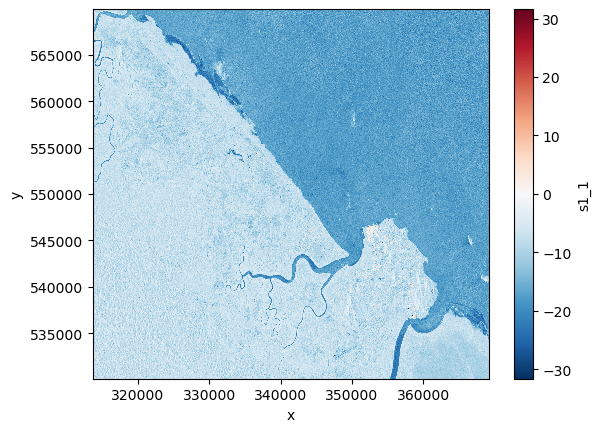

In [89]:
ds["s1_1"].plot()

In [ ]:
classid_da = xr.DataArray(
    labels_rs.sel(band=1).values, 
    dims=['y', 'x'], 
    coords={'y': ds_s2_stack['y'], 'x': ds_s2_stack['x']}
)

In [11]:
s1_stack

<xarray.DataArray (band: 1, y: 4011, x: 5592)>
[22429512 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 3.137e+05 3.137e+05 ... 3.692e+05 3.692e+05
  * y            (y) float64 5.699e+05 5.699e+05 ... 5.301e+05 5.301e+05
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    DataType:       9
    METADATATYPE:   OTB
    NoData:         0
    OTB_VERSION:    8.1.0
    TileHintX:      64
    TileHintY:      64
    _FillValue:     0.0
    scale_factor:   1.0
    add_offset:     0.0

In [10]:
ds_s2_stack

<xarray.Dataset>
Dimensions:      (y: 4011, x: 5592)
Coordinates:
  * x            (x) float64 3.137e+05 3.137e+05 ... 3.692e+05 3.692e+05
  * y            (y) float64 5.699e+05 5.699e+05 ... 5.301e+05 5.301e+05
    spatial_ref  int64 0
Data variables:
    1            (y, x) float32 ...
    2            (y, x) float32 ...
    3            (y, x) float32 ...
    4            (y, x) float32 ...
    5            (y, x) float32 ...
    6            (y, x) float32 ...
    7            (y, x) float32 ...
    8            (y, x) float32 ...
    9            (y, x) float32 ...
    10           (y, x) float32 ...
    classid      (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/16)
    AREA_OR_POINT:             Area
    DataType:                  3
    METADATATYPE:              OTB
    NoData:                    0
    OTB_VERSION:               8.1.0
    STATISTICS_APPROXIMATE:    YES
    ...                        ...
    STATISTICS_VALID_PERCENT:  100
    TileHintX:                 128
    TileHintY:                 128
    _FillValue:                0.0
    scale_factor:              1.0
    add_offset:                0.0

In [11]:
train = ds_s2_stack.to_dataframe()

In [12]:
train.head()

1            2            3  \
y             x                                                     
569949.059525 313663.218063  603.542297  1667.875977  4032.712158   
              313673.157106  587.224121  1619.221802  3933.274170   
              313683.096148  588.657593  1623.990112  3930.947510   
              313693.035191  576.008179  1595.099487  3875.432373   
              313702.974233  543.375793  1520.455200  3732.842285   

                                       4            5            6  \
y             x                                                      
569949.059525 313663.218063  3559.324951  3613.906250  2726.961426   
              313673.157106  3432.135254  3517.195557  2658.393311   
              313683.096148  3579.618408  3512.254395  2641.704590   
              313693.035191  3534.361328  3471.505371  2589.460693   
              313702.974233  3267.233887  3363.944824  2480.585449   

                                      7           8           9          10  \
y             x                                                               
569949.059525 313663.218063  882.746216  527.968262  900.590027  980.362610   
              313673.157106  862.901733  484.741699  851.628662  944.887634   
              313683.096148  850.858948  486.057037  845.677063  949.313965   
              313693.035191  836.705933  480.178528  839.797241  942.839844   
              313702.974233  810.577148  457.632111  796.618835  890.338684   

                             spatial_ref  classid  
y             x                                    
569949.059525 313663.218063            0      0.0  
              313673.157106            0      0.0  
              313683.096148            0      0.0  
              313693.035191            0      0.0  
              313702.974233            0      0.0

In [26]:
X

array([[  87.693275,  116.60314 ,  212.0057  , ...,  344.02744 ,
         622.5259  ,  824.89496 ],
       [  87.37334 ,  121.13122 ,  217.44048 , ...,  372.32956 ,
         644.37836 ,  867.7761  ],
       [  84.46779 ,  122.58131 ,  215.28986 , ...,  386.2856  ,
         705.61505 ,  925.02527 ],
       ...,
       [2331.1199  , 2999.8242  , 4442.107   , ..., 2430.8025  ,
        2384.0762  , 2269.8564  ],
       [1718.0564  , 2288.3088  , 3581.185   , ..., 1486.3058  ,
        1546.5245  , 1504.554   ],
       [1308.0333  , 1842.5702  , 3040.6987  , ...,  917.5383  ,
        1034.104   , 1095.7173  ]], dtype=float32)

In [18]:
X_tmp = ds_s2_stack.to_array().data[:10, :, :]
X_tmp.transpose(1, 2, 0)

array([[[ 603.5423  , 1667.876   , 4032.7122  , ...,  527.96826 ,
          900.59    ,  980.3626  ],
        [ 587.2241  , 1619.2218  , 3933.2742  , ...,  484.7417  ,
          851.62866 ,  944.88763 ],
        [ 588.6576  , 1623.9901  , 3930.9475  , ...,  486.05704 ,
          845.67706 ,  949.31396 ],
        ...,
        [ 130.97173 ,  169.30492 ,  273.65637 , ...,  457.86862 ,
          760.2749  ,  978.5611  ],
        [ 134.63387 ,  167.27237 ,  274.3675  , ...,  439.59995 ,
          695.6083  ,  911.83844 ],
        [ 128.9608  ,  161.4471  ,  265.79706 , ...,  403.61774 ,
          650.7106  ,  856.45715 ]],

       [[ 598.4728  , 1656.263   , 4060.617   , ...,  508.4926  ,
          875.7373  ,  977.22656 ],
        [ 575.20013 , 1594.4144  , 3924.4797  , ...,  464.19662 ,
          805.2802  ,  910.229   ],
        [ 553.999   , 1529.1155  , 3732.41    , ...,  444.56714 ,
          750.39026 ,  863.7304  ],
        ...,
        [ 128.65297 ,  166.17674 ,  260.52225 , ...,  

In [20]:
train = train[train.classid !=0]

In [21]:
coords = list(train.index)

In [22]:
train = (
    train
    .drop("spatial_ref", axis=1)
    .reset_index(drop=True)
)

In [23]:
train.classid.value_counts()

6.0     225949
1.0      52132
2.0      48323
4.0      20701
13.0     20424
7.0      18055
12.0     17397
3.0      14679
11.0     13263
5.0      11393
Name: classid, dtype: int64

Attention à l'ordre des columns => ne correspond pas au numéro de bands, cf pansharpening

In [24]:
X = train.drop("classid", axis=1).values
y = train["classid"].values

In [25]:
X.shape

(442316, 10)

In [28]:
y.shape

(442316,)

### Save

In [65]:
np.save(os.path.join(out_dir, 's2_stack.npy'), X)

In [ ]:
y = y.astype(np.int16)
np.save(os.path.join(out_dir, 'labels.npy'), y)

In [ ]:
#ds_s2_stack.rio.to_raster(os.path.join(data_dir, 's2_stack_labels.tif'))

In [17]:
labels.classid = labels.classid.astype(np.int8)

In [18]:
# save labels
labels.to_file(os.path.join(data_dir, "ROI_Classif_corrected_clf.shp"))

### Remarques

* `mask` de rasterio pour extraire les pixels à la place de rasterizer les labels.
* Cast pandas DataFrame peu adapté aux tres larges tif